In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/turkishstopwords/turkce-stop-words.txt
/kaggle/input/multiclass-classification-data-for-turkish-tc32/ticaret-yorum.csv


In [2]:
!pip install bertopic
import numpy as np
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
import pandas as pd
import nltk
import gensim
import gensim.corpora as corpora
import gensim.downloader as api
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 39.7 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 7.8 MB/s eta 0:00:00
Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=819466 sha256=59a43c2048b4564edf698a0751f8dd0e12e17ab7c6570ec210ce717e4054ef4a
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    

2024-03-16 19:55:05.724894: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 19:55:05.724993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 19:55:05.882632: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv("/kaggle/input/multiclass-classification-data-for-turkish-tc32/ticaret-yorum.csv")
with open("/kaggle/input/turkishstopwords/turkce-stop-words.txt", "r", encoding="utf-8") as file:
    stopwords_txt = file.readlines()

In [4]:
fulltext = ""
for i in range(len(df)):
    if i > 1:
        fulltext += df.iloc[i]['text'] + ' '

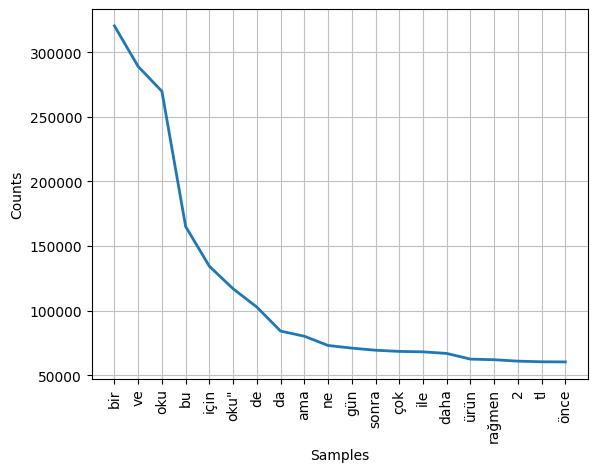

In [5]:
lower_text = nltk.FreqDist(fulltext.lower().split(" "))
lower_text.plot(20,cumulative=False)

In [6]:
stopwordsList = [word.strip() for word in stopwords_txt]
def clean_text(fultext):
    fultext = re.sub(r'<.*?>', '', fultext)  
    fultext = re.sub(r'\n', ' ', fultext)  
    fultext = re.sub(r'\t', ' ', fultext) 
    fultext = re.sub(r'\s+', ' ', fultext) 
    fultext = fultext.lower()
    fultext = re.sub(r'http\S+', '', fultext)
    fultext = re.sub(r"#(\w+)", '', fultext)
    fultext = re.sub(r"@(\w+)", '', fultext)
    fultext = re.sub(r'[^\w\s]', '', fultext)
    fultext = fultext.strip().lower()
    fultext = fultext.replace('&nbsp;', ' ').replace('“', ' ').replace('·', ' ').replace('i̇','i')
    fultext = fultext.replace('•', ' ').replace('\xa0', ' ')
    fultext = fultext.replace('”', ' ').replace('nan', '').replace('\r', '').replace('’', ' ')
    fultext = " ".join([word for word in fultext.split() if word not in stopwordsList])
    return fultext

In [7]:
df['Clean'] = df['text'].apply(clean_text)

In [8]:
fulltext_clean = ""
for i in range(len(df)):
    if i > 1:
        fulltext_clean += df.iloc[i]['Clean'] + ' '

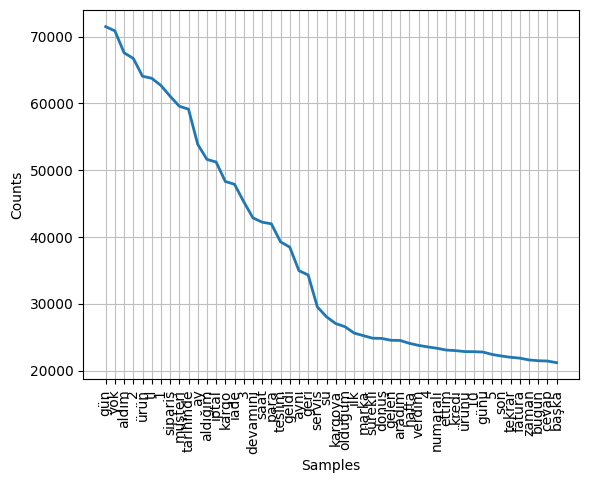

In [9]:
text_clean_freq = nltk.FreqDist(fulltext_clean.lower().split(" "))
text_clean_freq.plot(50,cumulative=False)

In [10]:
def sınıf_etiket(df):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df['Clean'])
    for class_label in df['category'].unique():
        class_documents = df[df['category'] == class_label]['Clean']
        class_tfidf = tfidf_matrix[class_documents.index]
        top_terms = vectorizer.get_feature_names_out()[class_tfidf.sum(axis=0).argsort()[:, ::-1][:, :5]]
        print(f"{class_label} 'Sınıfına etkili ilk 5 kelime':")
        print(top_terms)
        print('')
sınıf_etiket(df)

alisveris 'Sınıfına etkili ilk 5 kelime':
[['boyner' 'tedarik' 'ürün' 'sipariş' 'kargoya']]

anne-bebek 'Sınıfına etkili ilk 5 kelime':
[['ebebek' 'bebek' 'ürün' 'bez' 'joker']]

beyaz-esya 'Sınıfına etkili ilk 5 kelime':
[['servis' 'makinesi' 'arçelik' 'çamaşır' 'bulaşık']]

bilgisayar 'Sınıfına etkili ilk 5 kelime':
[['bilgisayar' 'lenovo' 'hp' 'ekran' 'asus']]

cep-telefon-kategori 'Sınıfına etkili ilk 5 kelime':
[['huawei' 'telefon' 'samsung' 'şarj' 'ekran']]

egitim 'Sınıfına etkili ilk 5 kelime':
[['dr' 'kitap' 'sipariş' 'kargoya' 'siparişim']]

elektronik 'Sınıfına etkili ilk 5 kelime':
[['tv' 'vestel' 'smart' 'youtubecom' 'televizyon']]

emlak-ve-insaat 'Sınıfına etkili ilk 5 kelime':
[['boya' 'su' 'ev' 'inşaat' 'arıtma']]

enerji 'Sınıfına etkili ilk 5 kelime':
[['elektrik' 'fatura' 'tl' 'doğalgaz' 'igdaş']]

etkinlik-ve-organizasyon 'Sınıfına etkili ilk 5 kelime':
[['cinemaximum' 'bilet' 'düğün' 'film' 'sinema']]

finans 'Sınıfına etkili ilk 5 kelime':
[['kredi' 'bankası' 'zi

In [11]:
data = df['Clean'].sample(n=50000, random_state=42)
categories = df.loc[data.index]['category'].tolist()
docs = data.tolist()

In [12]:
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
vectorizer_model = CountVectorizer(ngram_range=(1, 2))
ctfidf_model = ClassTfidfTransformer()

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
topic_model = BERTopic(
  language = "multilingual",
  embedding_model=embedding_model,    
  umap_model=umap_model,              
  hdbscan_model=hdbscan_model,        
  vectorizer_model=vectorizer_model,  
  ctfidf_model=ctfidf_model,          
  nr_topics="auto",
  calculate_probabilities=True
)

In [14]:
topics, probabilities = topic_model.fit_transform(data)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [15]:
freq = topic_model.get_topic_info()
freq.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,16194,-1_ürün_yok_aldım_tl,"[ürün, yok, aldım, tl, gün, müşteri, iade, ald...",[ebebek 10 gün ücret iadesi yapmadılar19022020...
1,0,29937,0_gün_sipariş_tarihinde_yok,"[gün, sipariş, tarihinde, yok, tl, müşteri, ip...",[bershka 15 aydır ürünümü bekliyorum iade yapı...
2,1,536,1_optik_atasun_gözlük_atasun optik,"[optik, atasun, gözlük, atasun optik, gözlüğü,...",[atasun optik farklı kalitede gözlükkonya merk...
3,2,327,2_eğitim_eba_eğitim bilişim_ders,"[eğitim, eba, eğitim bilişim, ders, eba eğitim...",[eba eğitim bilişim ağı eba eğitim bilişim ağı...
4,3,287,3_pizza_dominos_dominos pizza_sipariş,"[pizza, dominos, dominos pizza, sipariş, dakik...",[dominos pizza müşteriye saygısızlık sorunuoğl...
5,4,215,4_boya_renk_marshall_gri,"[boya, renk, marshall, gri, rengi, polisan, li...",[marshall boya boya rengi uyumsuzgeçtiğimiz ha...
6,5,180,5_belediyesi_çöp_mahallesi_büyükşehir,"[belediyesi, çöp, mahallesi, büyükşehir, büyük...",[bayraklı belediyesi adalet mahallesi pislikte...
7,6,173,6_yüzük_atasay_pırlanta_yüzüğü,"[yüzük, atasay, pırlanta, yüzüğü, altınbaş, ku...",[atasay kuyumculuk defalarca düşen taşatasayda...
8,7,163,7_düğün_salonu_kapora_düğün salonu,"[düğün, salonu, kapora, düğün salonu, balo, ne...",[altınsaray balo salonu kaporamı vermiyor30062...
9,8,151,8_fotoğraf_foto_fotoğrafçılık_düğün,"[fotoğraf, foto, fotoğrafçılık, düğün, fotoğra...",[foto burç müşteriye saygısızlıkkonya zaferde ...


In [16]:
topic_model.visualize_barchart(top_n_topics = 20)

In [17]:
topics_per_class = topic_model.topics_per_class(docs, classes=categories)
topic_model.visualize_topics_per_class(topics_per_class)

In [18]:
df_topics_per_class = pd.DataFrame(topics_per_class)
sorted_df = df_topics_per_class.sort_values(by='Frequency',ascending=False)
sorted_df

,Topic,Words,Frequency,Class,Name
29,0,"hastanesi, doktor, muayene, randevu, özel",1446,saglik,0_gün_sipariş_tarihinde_yok
139,0,"tv, vestel, smart, televizyon, youtubecom",1233,elektronik,0_gün_sipariş_tarihinde_yok
70,0,"sigorta, emeklilik, hayat, sigortası, iptal",1229,sigortacilik,0_gün_sipariş_tarihinde_yok
159,0,"telefon, huawei, samsung, samsung telefon, şarj",1223,cep-telefon-kategori,0_gün_sipariş_tarihinde_yok
185,0,"su, hayat içecek, hayat, içecek, danone",1180,icecek,0_gün_sipariş_tarihinde_yok
...,...,...,...,...,...
65,8,"gizli soru, gizli, soru, görüntüsünü ilettim, ...",1,finans,8_fotoğraf_foto_fotoğrafçılık_düğün
67,21,"apple, spotify, sorunuinternetten spotify, spo...",1,finans,21_apple_store_apple store_para
198,20,"park alanı, alanı, park, öğrendim site, nisan mah",1,kamu-hizmetleri,20_davlumbaz_kumtel_davlumbazın_ankastre
200,26,"müdürlüğüne, vergi, 6720348704, yeşil kartlıyı...",1,kamu-hizmetleri,26_profesyonel destek_green card_green_c...


In [19]:
def konu_benzerlik(topic_model):
    topic_embeddings = topic_model.topic_embeddings_
    distance_matrix = cosine_similarity(topic_embeddings)
    for i in range(len(distance_matrix)):
        print(f"Konu {i}:")
        similar_topics = [(j, distance_matrix[i][j]) for j in range(len(distance_matrix)) if j != i]
        similar_topics.sort(key=lambda x: x[1], reverse=True)
        for similar_topic, similarity in similar_topics[:5]:
            print(f"    Benzerlik: {similarity:.2f} - Konu {similar_topic}")
        print()
konu_benzerlik(topic_model)

Konu 0:
    Benzerlik: 0.99 - Konu 1
    Benzerlik: 0.72 - Konu 10
    Benzerlik: 0.71 - Konu 18
    Benzerlik: 0.69 - Konu 42
    Benzerlik: 0.67 - Konu 7

Konu 1:
    Benzerlik: 0.99 - Konu 0
    Benzerlik: 0.72 - Konu 10
    Benzerlik: 0.71 - Konu 18
    Benzerlik: 0.69 - Konu 42
    Benzerlik: 0.67 - Konu 37

Konu 2:
    Benzerlik: 0.62 - Konu 18
    Benzerlik: 0.58 - Konu 1
    Benzerlik: 0.58 - Konu 0
    Benzerlik: 0.58 - Konu 46
    Benzerlik: 0.55 - Konu 36

Konu 3:
    Benzerlik: 0.72 - Konu 16
    Benzerlik: 0.71 - Konu 15
    Benzerlik: 0.61 - Konu 1
    Benzerlik: 0.61 - Konu 0
    Benzerlik: 0.52 - Konu 18

Konu 4:
    Benzerlik: 0.60 - Konu 0
    Benzerlik: 0.58 - Konu 1
    Benzerlik: 0.51 - Konu 10
    Benzerlik: 0.48 - Konu 12
    Benzerlik: 0.47 - Konu 8

Konu 5:
    Benzerlik: 0.55 - Konu 7
    Benzerlik: 0.55 - Konu 0
    Benzerlik: 0.51 - Konu 1
    Benzerlik: 0.51 - Konu 18
    Benzerlik: 0.51 - Konu 9

Konu 6:
    Benzerlik: 0.68 - Konu 14
    Benzerlik: 0.68 - 

In [20]:
topic_model.get_document_info(docs)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,ferhat şenol avukatlık saygısızlık0 232 287 0 ...,0,0_gün_sipariş_tarihinde_yok,"[gün, sipariş, tarihinde, yok, tl, müşteri, ip...",[bershka 15 aydır ürünümü bekliyorum iade yapı...,gün - sipariş - tarihinde - yok - tl - müşteri...,0.738944,False
1,cinemaximum sinemia haksızlığıxxx pnr numarası...,0,0_gün_sipariş_tarihinde_yok,"[gün, sipariş, tarihinde, yok, tl, müşteri, ip...",[bershka 15 aydır ürünümü bekliyorum iade yapı...,gün - sipariş - tarihinde - yok - tl - müşteri...,0.553927,False
2,istwest yönetimi kötükentsel yönetimin idaresi...,-1,-1_ürün_yok_aldım_tl,"[ürün, yok, aldım, tl, gün, müşteri, iade, ald...",[ebebek 10 gün ücret iadesi yapmadılar19022020...,ürün - yok - aldım - tl - gün - müşteri - iade...,0.651061,False
3,prestij halı yıkama ankara gölbaşı halımı yakt...,-1,-1_ürün_yok_aldım_tl,"[ürün, yok, aldım, tl, gün, müşteri, iade, ald...",[ebebek 10 gün ücret iadesi yapmadılar19022020...,ürün - yok - aldım - tl - gün - müşteri - iade...,0.603761,False
4,danone hayat içecek vodafone su kampanyasıdün ...,0,0_gün_sipariş_tarihinde_yok,"[gün, sipariş, tarihinde, yok, tl, müşteri, ip...",[bershka 15 aydır ürünümü bekliyorum iade yapı...,gün - sipariş - tarihinde - yok - tl - müşteri...,0.385335,False
...,...,...,...,...,...,...,...,...
49995,igdaş ay fatura yüksek geldidoğalgaz faturam z...,0,0_gün_sipariş_tarihinde_yok,"[gün, sipariş, tarihinde, yok, tl, müşteri, ip...",[bershka 15 aydır ürünümü bekliyorum iade yapı...,gün - sipariş - tarihinde - yok - tl - müşteri...,0.232285,False
49996,ege vitrifiye tiyana modeli klozet çatlak oluş...,-1,-1_ürün_yok_aldım_tl,"[ürün, yok, aldım, tl, gün, müşteri, iade, ald...",[ebebek 10 gün ücret iadesi yapmadılar19022020...,ürün - yok - aldım - tl - gün - müşteri - iade...,0.913578,False
49997,emsan mutfak yakamoz çelik tencere kapağı kırı...,-1,-1_ürün_yok_aldım_tl,"[ürün, yok, aldım, tl, gün, müşteri, iade, ald...",[ebebek 10 gün ücret iadesi yapmadılar19022020...,ürün - yok - aldım - tl - gün - müşteri - iade...,0.582410,False
49998,yunus emre tıp merkezi çocuk sağlığı basit olm...,0,0_gün_sipariş_tarihinde_yok,"[gün, sipariş, tarihinde, yok, tl, müşteri, ip...",[bershka 15 aydır ürünümü bekliyorum iade yapı...,gün - sipariş - tarihinde - yok - tl - müşteri...,0.847325,False


In [21]:
data_output = topic_model.get_document_info(docs)
output = pd.DataFrame(data_output)

In [22]:
def clean_name(text):
    parts = text.split("_",maxsplit=1)
    return parts[1] if len(parts) > 1 else text
output["Name"] = output["Name"].apply(clean_name)

## Removing Outlier -1's

In [23]:
new_topics = topic_model.reduce_outliers(docs, topics, strategy="embeddings")
topic_model.update_topics(docs,topics= new_topics)

2024-03-16 20:06:44,542 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [24]:
topic_model.visualize_barchart(top_n_topics = 20)

In [25]:
freq = topic_model.get_topic_info()
freq.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,0,39247,0_gün_sipariş_müşteri_ürün,"[gün, sipariş, müşteri, ürün, yok, tl, tarihin...",[bershka 15 aydır ürünümü bekliyorum iade yapı...
1,1,598,1_optik_atasun_gözlük_gözlüğü,"[optik, atasun, gözlük, gözlüğü, optikten, gün...",[atasun optik farklı kalitede gözlükkonya merk...
2,2,561,2_eğitim_eba_ders_bilişim,"[eğitim, eba, ders, bilişim, giriş, ağı, sınıf...",[eba eğitim bilişim ağı eba eğitim bilişim ağı...
3,3,335,3_pizza_dominos_sipariş_dakika,"[pizza, dominos, sipariş, dakika, boy, pizzada...",[dominos pizza müşteriye saygısızlık sorunuoğl...
4,4,650,4_boya_renk_rengi_marshall,"[boya, renk, rengi, marshall, gri, beyaz, mavi...",[marshall boya boya rengi uyumsuzgeçtiğimiz ha...
5,5,546,5_belediyesi_büyükşehir_su_mahallesi,"[belediyesi, büyükşehir, su, mahallesi, çöp, s...",[bayraklı belediyesi adalet mahallesi pislikte...
6,6,317,6_yüzük_atasay_pırlanta_kuyumculuk,"[yüzük, atasay, pırlanta, kuyumculuk, altınbaş...",[atasay kuyumculuk defalarca düşen taşatasayda...
7,7,251,7_düğün_salonu_kapora_balo,"[düğün, salonu, kapora, balo, kına, kaporayı, ...",[altınsaray balo salonu kaporamı vermiyor30062...
8,8,220,8_fotoğraf_foto_fotoğrafçılık_düğün,"[fotoğraf, foto, fotoğrafçılık, düğün, fotoğra...",[foto burç müşteriye saygısızlıkkonya zaferde ...
9,9,179,9_vivense_ürün_teslim_vivenseden,"[vivense, ürün, teslim, vivenseden, koltuk, te...",[vivense eksik ürün teslimi 3 haftadır çözülem...


In [26]:
topics_per_class = topic_model.topics_per_class(docs, classes=categories)
topic_model.visualize_topics_per_class(topics_per_class,title=" Topic Model - Actual Category")

In [27]:
topic_model.visualize_heatmap(top_n_topics=40)

In [28]:
data_output = topic_model.get_document_info(docs)
output = pd.DataFrame(data_output)

In [29]:
def clean_name(text):
    parts = text.split("_",maxsplit=1)
    return parts[1] if len(parts) > 1 else text
output["Name"] = output["Name"].apply(clean_name)

In [30]:
document = pd.DataFrame({"Document":docs,
                        "ID": range(len(docs)),
                        "Topic": topic_model.topics_})

genel_df = topic_model.get_document_info(docs)
document["Actual Category"] = df["category"]
document["Topic_Name"] = genel_df["Name"]
document.drop(columns={"ID"},axis=1,inplace=True)

In [31]:
total_rows = len(genel_df)
topic_data = []
for topic_number in topics:
    filter_data = genel_df[genel_df["Topic"]==topic_number]
    percentage = (len(filter_data) / total_rows) * 100
    topic_data.append({"Topic": topic_number, "Row Count": len(filter_data), "Yüzde": percentage})
topic_data_df = pd.DataFrame(topic_data)
row_df = topic_data_df.sort_values(by="Yüzde", ascending=False)
row_df["Yüzde"] = row_df["Yüzde"].apply(lambda x: round(x, 2))
row_df = row_df.drop_duplicates()
row_df

,Topic,Row Count,Yüzde
49998,0,39247,78.49
27938,4,650,1.30
37823,1,598,1.20
48516,2,561,1.12
42283,5,546,1.09
44593,40,420,0.84
13888,25,394,0.79
24295,3,335,0.67
5169,51,335,0.67
37421,16,319,0.64


In [32]:
sorted_df = pd.merge(row_df,sorted_df,on=["Topic"])
sorted_df

,Topic,Row Count,Yüzde,Words,Frequency,Class,Name
0,0,39247,78.49,"hastanesi, doktor, muayene, randevu, özel",1446,saglik,0_gün_sipariş_tarihinde_yok
1,0,39247,78.49,"tv, vestel, smart, televizyon, youtubecom",1233,elektronik,0_gün_sipariş_tarihinde_yok
2,0,39247,78.49,"sigorta, emeklilik, hayat, sigortası, iptal",1229,sigortacilik,0_gün_sipariş_tarihinde_yok
3,0,39247,78.49,"telefon, huawei, samsung, samsung telefon, şarj",1223,cep-telefon-kategori,0_gün_sipariş_tarihinde_yok
4,0,39247,78.49,"su, hayat içecek, hayat, içecek, danone",1180,icecek,0_gün_sipariş_tarihinde_yok
...,...,...,...,...,...,...,...
324,-1,0,0.00,"cinemaximum, bilet, kına, film, düğün",371,etkinlik-ve-organizasyon,-1_ürün_yok_aldım_tl
325,-1,0,0.00,"dr, eğitim, ürün, eba, sipariş",337,egitim,-1_ürün_yok_aldım_tl
326,-1,0,0.00,"saat, saat saat, atasay, ürün, iade",290,mucevher-saat-gozluk,-1_ürün_yok_aldım_tl
327,-1,0,0.00,"sigorta, sigortası, hasar, kredi, allianz",264,sigortacilik,-1_ürün_yok_aldım_tl


In [33]:
sorted_df.rename(columns={"Frequency":"Matching Rows","Class":"Actual Category","Name":"Topic Category"},inplace=True)
sorted_df

,Topic,Row Count,Yüzde,Words,Matching Rows,Actual Category,Topic Category
0,0,39247,78.49,"hastanesi, doktor, muayene, randevu, özel",1446,saglik,0_gün_sipariş_tarihinde_yok
1,0,39247,78.49,"tv, vestel, smart, televizyon, youtubecom",1233,elektronik,0_gün_sipariş_tarihinde_yok
2,0,39247,78.49,"sigorta, emeklilik, hayat, sigortası, iptal",1229,sigortacilik,0_gün_sipariş_tarihinde_yok
3,0,39247,78.49,"telefon, huawei, samsung, samsung telefon, şarj",1223,cep-telefon-kategori,0_gün_sipariş_tarihinde_yok
4,0,39247,78.49,"su, hayat içecek, hayat, içecek, danone",1180,icecek,0_gün_sipariş_tarihinde_yok
...,...,...,...,...,...,...,...
324,-1,0,0.00,"cinemaximum, bilet, kına, film, düğün",371,etkinlik-ve-organizasyon,-1_ürün_yok_aldım_tl
325,-1,0,0.00,"dr, eğitim, ürün, eba, sipariş",337,egitim,-1_ürün_yok_aldım_tl
326,-1,0,0.00,"saat, saat saat, atasay, ürün, iade",290,mucevher-saat-gozluk,-1_ürün_yok_aldım_tl
327,-1,0,0.00,"sigorta, sigortası, hasar, kredi, allianz",264,sigortacilik,-1_ürün_yok_aldım_tl
